## Papers Read
https://arxiv.org/pdf/1706.03762

https://arxiv.org/pdf/1810.04805

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import torchtext
from torchtext import datasets
from torchtext import data
from torchtext.datasets import IMDB
from torchtext.vocab import Vocab
from torchtext.data import Example, Dataset

import mlxtend, torchmetrics

import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import math
import random
from collections import defaultdict

# Getting data ready

## Load dataset

Dataset Being used is from https://ai.stanford.edu/~amaas/data/sentiment/

This time I will be using WordPiece as my tokenizer, similar to the paper

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

text = "I absolutely loved this movie! It was amazing."

# Encode into WordPiece tokens
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# Convert to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

# Or directly encode into IDs (with [CLS] and [SEP])
encoded = tokenizer.encode_plus(
    text,
    add_special_tokens=True,   # adds [CLS] and [SEP]
    max_length=2400,
    truncation=True,
    padding="max_length",
    return_tensors="pt"        # returns PyTorch tensors
)

print(encoded["input_ids"])   # token IDs (with CLS, SEP, padding)
print(encoded["attention_mask"])  # 1 = real token, 0 = padding

Tokens: ['i', 'absolutely', 'loved', 'this', 'movie', '!', 'it', 'was', 'amazing', '.']
Token IDs: [1045, 7078, 3866, 2023, 3185, 999, 2009, 2001, 6429, 1012]
tensor([[ 101, 1045, 7078,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0]])


In [4]:
tokenizer.cls_token, tokenizer.sep_token

('[CLS]', '[SEP]')

In [5]:
#need to create this function to tokenize since i am using an old torchtext version 0.6.0
def tokenize_fn(text):
    # return [tokenizer.cls_token] + tokenizer.tokenize(text) + [tokenizer.sep_token]
    return  tokenizer.tokenize(text) 

In [6]:
train_text_field = data.Field(sequential=True,
                                tokenize=tokenize_fn,
                                lower=False,             
                                include_lengths=True,
                                use_vocab=True,
                                batch_first=True,        # helpful later for BERT models
                                pad_token=tokenizer.pad_token,
                                unk_token=tokenizer.unk_token,
                                init_token=tokenizer.cls_token,  # add [CLS] at start
                                eos_token=tokenizer.sep_token    # add [SEP] at end
                                )

train_label_field = data.Field(sequential=False, use_vocab=True, unk_token=None)

review_id_field = data.Field(sequential=False, use_vocab=False, unk_token=None)


In [7]:
# Load IMDB dataset
train_dataset, test_dataset = datasets.IMDB.splits(
    text_field=train_text_field,
    label_field=train_label_field
)


train_dataset, validation_dataset = train_dataset.split(
                                                        split_ratio=0.8,
                                                        random_state=random.seed(43)
)

### Understanding data

In [8]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(20000, 5000, 25000)

In [9]:
#find the longest tokenization
max_tokens_length = -1
for example in train_dataset:
    if len(example.text)>max_tokens_length:
        max_tokens_length = len(example.text)

max_tokens_length

2313

In [10]:
first_example = train_dataset[0]

In [11]:
full_first_example = ""
for token in first_example.text:
    full_first_example+=token
    full_first_example+= " "
    if(token=="."):
        full_first_example+='\n'

In [12]:
print("Text tokens:", first_example.text)
print("Full Review:", full_first_example)
print("Label:", first_example.label)

Text tokens: ['midnight', 'cowboy', 'made', 'a', 'big', 'fuss', 'when', 'it', 'was', 'released', 'in', '1969', ',', 'drawing', 'an', 'x', 'rating', '.', 'by', 'today', "'", 's', 'standards', ',', 'it', 'would', 'be', 'hard', 'pressed', 'to', 'pull', 'an', 'r', 'rating', '.', 'jon', 'vo', '##ight', ',', 'who', 'has', 'been', 'better', ',', 'is', 'competent', 'in', 'his', 'role', 'as', 'joe', 'buck', ',', 'an', 'out', 'of', 'town', 'hi', '##ck', 'wanting', 'to', 'make', 'it', 'big', 'with', 'the', 'ladies', 'in', 'new', 'york', 'city', '.', 'he', 'meets', 'a', 'seed', '##y', 'street', 'hu', '##stle', '##r', 'named', 'rats', '##o', 'ri', '##zzo', ',', 'who', 'tries', 'to', 'be', '##fr', '##ien', '##d', 'buck', 'for', 'his', 'own', 'purposes', '.', 'the', 'two', 'eventually', 'forge', 'a', 'bond', 'that', 'is', 'both', 'touching', 'and', 'pathetic', '.', 'as', 'rats', '##o', ',', 'dustin', 'hoffman', 'simply', 'shine', '##s', '.', 'hoffman', 'has', 'often', 'been', 'brilliant', ',', 'but',

## BERT has inputs in specific form

For example this sentence: "The movie was amazing and thrilling"

Will be split like: [CLS] the movie was amaz ##ing and thrill ##ing . [SEP]

Then it will assign an embedding for each token by summing:

    - Token vector embedding
    - Segment embedding (what sentence belongs to)
        - For my use I will just have each token belonging to the same sentence for ease of use
    - Position embedding

## Create dataloaders

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
train_dataset

In [15]:
train_text_field.build_vocab(train_dataset, 
                             vectors=None,  # we’ll replace this with BERT vocab later if needed
                             max_size=30000)

train_label_field.build_vocab(train_dataset)

Replace vocab with WordPiece vocab

In [16]:
from collections import Counter

# Create dummy counter since BERT vocab is prebuilt
dummy_counter = Counter()

# Initialize Vocab
train_text_field.vocab = Vocab(dummy_counter, specials=[])

# Load HuggingFace vocab
bert_vocab = tokenizer.get_vocab()  # dict: token → id

# Replace stoi and itos
train_text_field.vocab.stoi = bert_vocab
train_text_field.vocab.itos = {i: s for s, i in bert_vocab.items()}

In [17]:
train_text_field.vocab.stoi["loved"]

3866

In [18]:
sample = "I loved the movie, it was unbelievable!"
tokens = train_text_field.preprocess(sample)
print("Tokens:", tokens)

ids = [train_text_field.vocab.stoi[tok] for tok in tokens]
print("Token IDs:", ids)

# Compare with HuggingFace tokenizer
print("HuggingFace IDs:", tokenizer.convert_tokens_to_ids(tokens))


Tokens: ['i', 'loved', 'the', 'movie', ',', 'it', 'was', 'unbelievable', '!']
Token IDs: [1045, 3866, 1996, 3185, 1010, 2009, 2001, 23653, 999]
HuggingFace IDs: [1045, 3866, 1996, 3185, 1010, 2009, 2001, 23653, 999]


### Want to Chunk dataset inorder to have sequences less thatn 512 tokens for efficient compute

In [19]:
def chunk_dataset(original_dataset, max_len=512):
    all_examples = []

    for review_idx, example in enumerate(original_dataset):
        tokens = example.text  # already tokenized

        chunk_len = max_len - 2  # leave room for [CLS] and [SEP]
        
        # split into chunks
        for i in range(0, len(tokens), chunk_len):
            chunk_tokens = tokens[i:i + chunk_len]

            # add special tokens for every chunk
            # chunk_tokens = [original_dataset.fields['text'].init_token] + chunk_tokens + [original_dataset.fields['text'].eos_token]
            chunk_tokens =  chunk_tokens 

            # create a new Example with review_id field
            new_example = Example.fromlist(
                [chunk_tokens, example.label, review_idx],
                fields=[('text', original_dataset.fields['text']),
                        ('label', original_dataset.fields['label']),
                        ('review_id', review_id_field)]
            )
            all_examples.append(new_example)

    # include the review_id field in the dataset
    chunked_dataset = Dataset(all_examples, fields={
        'text': original_dataset.fields['text'],
        'label': original_dataset.fields['label'],
        'review_id': review_id_field
    })

    return chunked_dataset


In [20]:
BATCH_SIZE = 32

chunked_train_dataset = chunk_dataset(train_dataset, max_len=512)
chunked_val_dataset = chunk_dataset(validation_dataset, max_len=512)
chunked_test_dataset = chunk_dataset(test_dataset, max_len=512)


In [21]:
len(chunked_train_dataset[3].text)

510

In [22]:
train_iter = data.BucketIterator(
    dataset=chunked_train_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

validation_iter = data.BucketIterator(
    dataset=chunked_val_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

test_iter = data.BucketIterator(
    dataset=chunked_test_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

### Sanity Check of chunking

In [23]:
review_chunks = defaultdict(int)
for example in chunked_train_dataset:
    rid = getattr(example, 'review_id', None)
    if rid is not None:
        review_chunks[rid] += 1

# Inspect
print(f"Total original reviews: {len(train_dataset)}")
print(f"Total chunked examples: {len(chunked_train_dataset)}")
print(f"Average chunks per review: {sum(review_chunks.values())/len(review_chunks):.2f}")
print(f"Chunks for first 5 reviews: {[review_chunks[i] for i in range(5)]}")


Total original reviews: 20000
Total chunked examples: 23403
Average chunks per review: 1.17
Chunks for first 5 reviews: [1, 1, 1, 2, 1]


Minimum chunks per review: 1
Maximum chunks per review: 5
Median chunks per review: 1
Total chunks: 23403


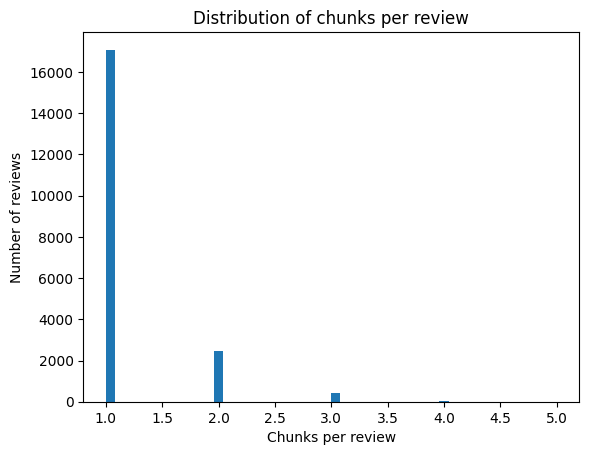

In [24]:
chunk_counts = list(review_chunks.values())

print(f"Minimum chunks per review: {min(chunk_counts)}")
print(f"Maximum chunks per review: {max(chunk_counts)}")
print(f"Median chunks per review: {sorted(chunk_counts)[len(chunk_counts)//2]}")
print(f"Total chunks: {sum(chunk_counts)}")

# Optional: plot histogram
plt.hist(chunk_counts, bins=50)
plt.xlabel("Chunks per review")
plt.ylabel("Number of reviews")
plt.title("Distribution of chunks per review")
plt.show()


In [25]:
for i in range(5):
    rid = i
    chunks_for_review = [ex for ex in chunked_train_dataset if ex.review_id == rid]
    print(f"\nReview ID {rid} has {len(chunks_for_review)} chunks")
    for j, chunk in enumerate(chunks_for_review):
        print(f"  Chunk {j} length: {len(chunk.text)} tokens")



Review ID 0 has 1 chunks
  Chunk 0 length: 225 tokens

Review ID 1 has 1 chunks
  Chunk 0 length: 298 tokens

Review ID 2 has 1 chunks
  Chunk 0 length: 220 tokens

Review ID 3 has 2 chunks
  Chunk 0 length: 510 tokens
  Chunk 1 length: 316 tokens

Review ID 4 has 1 chunks
  Chunk 0 length: 421 tokens


In [26]:
chunked_train_dataset[21].text 

['memoirs',
 'of',
 'a',
 'ge',
 '##isha',
 'is',
 'a',
 'beautifully',
 'filmed',
 'movie',
 ',',
 'there',
 'is',
 'no',
 'doubt',
 'about',
 'that',
 '.',
 'and',
 'the',
 'acting',
 'is',
 'generally',
 'excellent',
 ',',
 'at',
 'least',
 'in',
 'terms',
 'of',
 'how',
 'it',
 'portrays',
 'the',
 'characters',
 'as',
 'they',
 'are',
 'scripted',
 '.',
 '<',
 'br',
 '/',
 '>',
 '<',
 'br',
 '/',
 '>',
 'however',
 ',',
 'so',
 'many',
 'details',
 'small',
 'and',
 'large',
 'are',
 'just',
 '_',
 'wrong',
 '_',
 'that',
 'it',
 'just',
 'bother',
 '##s',
 'me',
 'too',
 'much',
 'to',
 'be',
 'able',
 'to',
 'enjoy',
 'it',
 'fully',
 '.',
 'a',
 'small',
 'detail',
 'that',
 'ty',
 '##pi',
 '##fies',
 'the',
 'kind',
 'of',
 'lack',
 'of',
 'sensitivity',
 'of',
 'sorts',
 'is',
 'one',
 'scene',
 '(',
 'no',
 'this',
 'does',
 'not',
 'spoil',
 'anything',
 ')',
 'where',
 'ma',
 '##me',
 '##ha',
 'rings',
 'a',
 'bell',
 'that',
 'hangs',
 'at',
 'the',
 'door',
 'of',
 'the'

In [27]:
cls_token = train_text_field.init_token
sep_token = train_text_field.eos_token

for i, example in enumerate(chunked_train_dataset[:10]):
    if example.text[0] != cls_token or example.text[-1] != sep_token:
        print(f"Chunk {i} missing special tokens")


Chunk 0 missing special tokens
Chunk 1 missing special tokens
Chunk 2 missing special tokens
Chunk 3 missing special tokens
Chunk 4 missing special tokens
Chunk 5 missing special tokens
Chunk 6 missing special tokens
Chunk 7 missing special tokens
Chunk 8 missing special tokens
Chunk 9 missing special tokens


In [28]:
# Check which review each chunk belongs to
for i in [3, 4]:
    ex = chunked_train_dataset[i]
    rid = getattr(ex, 'review_id', None)
    print(f"Chunk {i} belongs to review_id: {rid}")
    print(f"First 10 tokens: {ex.text[:10]}")
    print(f"Last 10 tokens: {ex.text[-10:]}\n")


Chunk 3 belongs to review_id: 3
First 10 tokens: ['hmm', '##m', ',', 'a', 'sports', 'team', 'is', 'in', 'a', 'plane']
Last 10 tokens: ['in', 'the', 'himalayas', ',', 'then', 'why', 'doesn', "'", 't', 'he']

Chunk 4 belongs to review_id: 3
First 10 tokens: ['know', 'enough', 'to', 'make', 'shelter', 'and', 'set', 'traps', 'right', 'from']
Last 10 tokens: ['the', 'very', 'end', ',', 'however', ',', 'is', 'quote', 'lame', '.']



In [29]:
rid_to_check = chunked_train_dataset[3].review_id
chunks_for_review = [ex for ex in chunked_train_dataset if ex.review_id == rid_to_check]
for j, ex in enumerate(chunks_for_review):
    print(f"Chunk {j} length: {len(ex.text)} tokens, first: {ex.text[:5]}, last: {ex.text[-5:]}")


Chunk 0 length: 510 tokens, first: ['hmm', '##m', ',', 'a', 'sports'], last: ['why', 'doesn', "'", 't', 'he']
Chunk 1 length: 316 tokens, first: ['know', 'enough', 'to', 'make', 'shelter'], last: [',', 'is', 'quote', 'lame', '.']


In [30]:
missing_ids = [ex for ex in chunked_train_dataset if getattr(ex, 'review_id', None) is None]
print(f"Chunks missing review_id: {len(missing_ids)}")


Chunks missing review_id: 0


In [31]:
for i in range(5):
    rid = i
    labels = set(ex.label for ex in chunked_train_dataset if ex.review_id == rid)
    print(f"Review {rid} labels in chunks: {labels}")


Review 0 labels in chunks: {'pos'}
Review 1 labels in chunks: {'pos'}
Review 2 labels in chunks: {'neg'}
Review 3 labels in chunks: {'neg'}
Review 4 labels in chunks: {'pos'}


In [32]:
chunk_lengths = [len(ex.text) for ex in chunked_train_dataset]
print(f"Max chunk length: {max(chunk_lengths)}")
print(f"Min chunk length: {min(chunk_lengths)}")
print(f"Average chunk length: {sum(chunk_lengths)/len(chunk_lengths):.2f}")


Max chunk length: 510
Min chunk length: 1
Average chunk length: 265.85


In [33]:
print(f'Length of train_iter: {len(train_iter)} batches of {BATCH_SIZE}')

Length of train_iter: 732 batches of 32


In [34]:
len(train_iter), len(validation_iter), len(test_iter)

(732, 185, 908)

In [35]:
train_text_field.vocab

In [36]:
#let's see what is in train_iter
first_batch = next(iter(train_iter))
first_batch


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.cuda.LongTensor of size 32x254 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.review_id]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [37]:
first_batch_features, first_batch_lengths = first_batch.text
first_batch_labels = first_batch.label

In [38]:
first_batch_features.shape, first_batch_lengths.shape, first_batch_labels.shape

(torch.Size([32, 254]), torch.Size([32]), torch.Size([32]))

In [39]:
first_batch_features[21,:]

tensor([  101,  1996,  3185,  2003, 10468,  1996,  2466,  1997,  1037,  2845,
        19215,  1005,  1055,  2709,  2000,  2014,  2188,  2352,  2005,  1996,
         6715,  1997,  1037,  2905,  1013,  2767,  1012,  2045,  2024,  1037,
         3232,  1997,  2060,  3576,  2466,  3210,  2008,  2453,  2941,  2022,
         2062,  5875,  2084,  1996,  2028,  2579,  1010,  2021,  2027,  2024,
         2025,  3929, 10641,  1012,  1996,  4563,  1997,  1996,  3185,  2003,
         1996,  6715,  1010,  5256,  1010,  1998,  2101,  6704,  2058,  1996,
         2925,  1997,  1037,  2451,  1997, 13675, 21821,  2008,  2191, 14421,
         1998,  5271,  2068,  2000,  4965, 21092,  2021,  2024,  2085,  4394,
         1996,  3063,  2040,  2081,  2037, 14421,  3006,  3085,  1012,  4593,
         1010,  1996,  3185,  2003, 16655, 23194,  2098,  1012,  1996, 19215,
         1005,  1055,  4990,  2013,  1996,  2103,  2000,  1996,  2352,  2003,
         2019,  4654, 26775, 14194, 15370,  2135, 10866,  3345, 

In [40]:
torch.manual_seed(26)
random_index = torch.randint(0, 32, size=[1]).item()
print(random_index)

review, label = first_batch_features[random_index,:], first_batch_labels[random_index]

21


In [41]:
review

tensor([  101,  1996,  3185,  2003, 10468,  1996,  2466,  1997,  1037,  2845,
        19215,  1005,  1055,  2709,  2000,  2014,  2188,  2352,  2005,  1996,
         6715,  1997,  1037,  2905,  1013,  2767,  1012,  2045,  2024,  1037,
         3232,  1997,  2060,  3576,  2466,  3210,  2008,  2453,  2941,  2022,
         2062,  5875,  2084,  1996,  2028,  2579,  1010,  2021,  2027,  2024,
         2025,  3929, 10641,  1012,  1996,  4563,  1997,  1996,  3185,  2003,
         1996,  6715,  1010,  5256,  1010,  1998,  2101,  6704,  2058,  1996,
         2925,  1997,  1037,  2451,  1997, 13675, 21821,  2008,  2191, 14421,
         1998,  5271,  2068,  2000,  4965, 21092,  2021,  2024,  2085,  4394,
         1996,  3063,  2040,  2081,  2037, 14421,  3006,  3085,  1012,  4593,
         1010,  1996,  3185,  2003, 16655, 23194,  2098,  1012,  1996, 19215,
         1005,  1055,  4990,  2013,  1996,  2103,  2000,  1996,  2352,  2003,
         2019,  4654, 26775, 14194, 15370,  2135, 10866,  3345, 

Each word is assigned an index

In [42]:
string = ""
for word in [train_text_field.vocab.itos[index.item()] for index in review]:
    # print(index)
    string += word + " "

print(string)
print(label)

[CLS] the movie is basically the story of a russian prostitute ' s return to her home village for the funeral of a sister / friend . there are a couple of other minor story lines that might actually be more interesting than the one taken , but they are not fully explored . the core of the movie is the funeral , wake , and later controversy over the future of a community of cr ##ones that make dolls and sell them to buy vodka but are now missing the artist who made their dolls market ##able . apparently , the movie is une ##dit ##ed . the prostitute ' s journey from the city to the village is an ex ##cr ##uc ##iating ##ly endless train ride and tram ##p through the mud . maybe that ' s supposed to impress us with the im ##men ##sity of the russian landscape . the village itself , such as it is , is inhabited by a legion of widows and one male , the consort of the dead girl . continuing the doll business is problematic for everyone involved and eventually seems impossible . most of the f

## Mapping vocab to vectors

In [43]:
bert = BertModel.from_pretrained('bert-base-uncased')

In [44]:
max(train_text_field.vocab.itos)

30521

In [45]:
vector_embedding_matrix = bert.embeddings.word_embeddings.weight.clone().detach()

In [46]:
vector_embedding_matrix.shape

torch.Size([30522, 768])

Now, each index in train_text_field.vocab.itos is mapped to a length 300 vector embedding

In [47]:
train_text_field.vocab.itos[0]

'[PAD]'

In [48]:
vector_embedding_matrix[1996][:5], bert.embeddings.word_embeddings.weight[1996][:5]

(tensor([-0.0446,  0.0061, -0.0022,  0.0023, -0.0365]),
 tensor([-0.0446,  0.0061, -0.0022,  0.0023, -0.0365], grad_fn=<SliceBackward0>))

The embedding matrix has each word mapped to a vector now

## Now need to take into account the token, positional, and segment embeddings

In [49]:
def sinusoidal_embeddings(max_len, hidden_size, device=device):
    # Create position indices [0, 1, ..., max_len-1]
    position = torch.arange(max_len, dtype=torch.float, device=device).unsqueeze(1)
    # Create dimension indices [0, 1, ..., hidden_size-1]
    div_term = torch.exp(torch.arange(0, hidden_size, 2, dtype=torch.float, device=device) *
                         -(math.log(10000.0) / hidden_size))
    
    pe = torch.zeros(max_len, hidden_size, device=device)
    pe[:, 0::2] = torch.sin(position * div_term)   # apply sin to even indices
    pe[:, 1::2] = torch.cos(position * div_term)   # apply cos to odd indices
    
    return pe  # shape: [max_len, hidden_size]


In [50]:
positional_embedding_matrix = sinusoidal_embeddings(max_len=2400, hidden_size=768)

In [51]:
positional_embedding_matrix.shape

torch.Size([2400, 768])

In [52]:
_, seq_len = first_batch_features.size()
_, seq_len

(32, 254)

In [53]:
first_batch_pos_embeds = positional_embedding_matrix[:seq_len, :].unsqueeze(0).expand(BATCH_SIZE, -1, -1)
first_batch_pos_embeds.shape

torch.Size([32, 254, 768])

## Creating the Embedding Layer

In [54]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, hidden_dim: int):
        super().__init__()
        # Precompute sinusoidal matrix [max_len, hidden_dim]
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / hidden_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # [1, max_len, hidden_dim]

    def forward(self, seq_len: int, batch_size: int):
        # Return only the slice needed
        return self.pe[:, :seq_len, :].expand(batch_size, -1, -1)


In [55]:
class BERTEmbeddings(nn.Module):
    def __init__(self, emb_matrix: torch.Tensor, max_len: int = 512):
        super().__init__()
        vocab_size, hidden_dim = emb_matrix.shape
        
        # Token embeddings (frozen BERT pretrained embeddings you built earlier)
        self.token_embeddings = nn.Embedding.from_pretrained(
            emb_matrix, freeze=True, padding_idx=0
        )

        # Segment embeddings (2 segments: sentence A = 0, sentence B = 1, but you only need 1)
        self.segment_embeddings = nn.Embedding(2, hidden_dim)

        # Positional embeddings (sinusoidal, not trainable)
        self.positional_embeddings = PositionalEmbedding(max_len, hidden_dim)

    def forward(self, input_ids, segment_ids=None):
        """
        input_ids: [batch_size, seq_len]
        segment_ids: [batch_size, seq_len] (default 0s if not provided)
        """
        batch_size, seq_len = input_ids.size()
        
        if segment_ids is None:
            segment_ids = torch.zeros_like(input_ids)

        token_embeds = self.token_embeddings(input_ids)                    # [B, L, H]
        segment_embeds = self.segment_embeddings(segment_ids)              # [B, L, H]
        pos_embeds = self.positional_embeddings(seq_len, batch_size)       # [B, L, H]

        return token_embeds + segment_embeds + pos_embeds                  # [B, L, H]

In [56]:
#testing out making sure the embeddings work before plugging into transformer model
embedding_model = BERTEmbeddings(vector_embedding_matrix).to(device)
embedding_model

BERTEmbeddings(
  (token_embeddings): Embedding(30522, 768, padding_idx=0)
  (segment_embeddings): Embedding(2, 768)
  (positional_embeddings): PositionalEmbedding()
)

In [57]:
result = embedding_model(first_batch_features)
result.shape

torch.Size([32, 254, 768])

Having to decide to truncate my reviews to around 512 because i want to be able to process everything efficiently realistically

Will try to use chunking because I don't want to lose information from any review

# Helper Functions

In [58]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #torch.eq gets how many values are equal, them sum, them get only the item in the tensor
  acc = (correct/len(y_pred))*100
  return acc

In [59]:
def train_step(model: torch.nn.Module,
               data_iter: torchtext.data.BucketIterator,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               train_loss_per_epoch,
               device: torch.device = device):
    
    model.train()
    train_loss, train_acc = 0, 0

    for batch in data_iter:
        batch_features, batch_lengths = batch.text
        batch_labels = batch.label

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # forward pass
        pred_labels = model(batch_features, batch_lengths)

        # compute loss & accuracy per chunk
        loss = loss_fn(pred_labels, batch_labels.float())
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=batch_labels.float(),
                                 y_pred=torch.round(torch.sigmoid(pred_labels)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average over batches
    train_loss /= len(data_iter)
    train_acc /= len(data_iter)

    train_loss_per_epoch.append(train_loss)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")

In [60]:
def valid_step_review_metrics(model: torch.nn.Module,
                              data_iter: torchtext.data.BucketIterator,
                              loss_fn: torch.nn.Module,
                              accuracy_fn,
                              valid_loss_per_epoch,
                              valid_acc_per_epoch,
                              device: torch.device = device):
    
    model.eval()
    valid_loss, valid_acc = 0, 0

    review_preds = defaultdict(list)
    review_labels = {}

    with torch.inference_mode():
        for batch in data_iter:
            batch_features, batch_lengths = batch.text
            batch_labels = batch.label
            batch_review_ids = batch.review_id  # tensor of size [batch_size]

            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            pred_logits = model(batch_features, batch_lengths)
            pred_probs = torch.sigmoid(pred_logits)

            # --- Chunk-level metrics ---
            valid_loss += loss_fn(pred_logits, batch_labels.float()).item()
            valid_acc += accuracy_fn(y_true=batch_labels.float(),
                                     y_pred=torch.round(pred_probs))

            # --- Collect predictions per review ---
            for i, rid in enumerate(batch_review_ids):
                review_preds[int(rid.item())].append(pred_probs[i].item())
                review_labels[int(rid.item())] = int(batch_labels[i].item())

    # Average chunk predictions per review
    y_true, y_pred, y_prob = [], [], []
    for rid in sorted(review_preds.keys()):
        avg_prob = sum(review_preds[rid]) / len(review_preds[rid])
        y_prob.append(avg_prob)
        y_pred.append(1 if avg_prob >= 0.5 else 0)
        y_true.append(review_labels[rid])

    review_acc = sum([yp == yt for yp, yt in zip(y_pred, y_true)]) / len(y_true)

    # Average chunk-level metrics
    valid_loss /= len(data_iter)
    valid_acc /= len(data_iter)

    valid_loss_per_epoch.append(valid_loss)
    valid_acc_per_epoch.append(valid_acc)

    print(f"Chunk-level loss: {valid_loss:.4f} | Chunk-level acc: {valid_acc:.4f}")
    print(f"Review-level acc: {review_acc:.4f}\n-----")

    return valid_loss, review_acc


In [61]:
def inference_mode_chunked(model, data_iter, device=device):
    """
    Inference for models trained on chunked data. Aggregates predictions per review.
    Works with torchtext 0.6.0 and chunked datasets.
    """
    model.eval()
    review_preds = defaultdict(list)  # store probs per review
    review_labels = {}                # store true label per review

    with torch.inference_mode():
        for batch in tqdm(data_iter, desc="Inference on chunks"):
            batch_features, batch_lengths = batch.text  # features and lengths
            batch_labels = batch.label
            batch_features = batch_features.to(device)

            # forward pass
            logits = model(batch_features, batch_lengths)
            probs = torch.sigmoid(logits).cpu()  # shape: [batch_size]

            # map each chunk to its review_id
            batch_review_ids = batch.review_id.cpu()  # shape: [batch_size]
            for i in range(batch_features.size(0)):
                rid = batch_review_ids[i].item()
                review_preds[rid].append(probs[i].item())
                review_labels[rid] = batch_labels[i].item()

    # Aggregate per review
    y_true, y_pred, y_prob = [], [], []
    for rid in sorted(review_preds.keys()):
        chunk_probs = review_preds[rid]
        avg_prob = sum(chunk_probs) / len(chunk_probs)
        y_prob.append(avg_prob)
        y_pred.append(1 if avg_prob >= 0.5 else 0)
        y_true.append(review_labels[rid])

    if len(y_true) == 0:
        print("⚠️ Warning: No review predictions found. Check that review_ids are set in dataset.")
        return None, None, None

    y_true_tensor = torch.tensor(y_true)
    y_pred_tensor = torch.tensor(y_pred)
    y_prob_tensor = torch.tensor(y_prob)

    correct = (y_pred_tensor == y_true_tensor).sum().item()
    total = len(y_true_tensor)
    print(f"Correct predictions: {correct}/{total} ({correct/total:.2%})")

    return y_pred_tensor, y_true_tensor, y_prob_tensor


In [62]:
# --- Function 1: Epoch-based curves ---
def plot_epoch_metrics(epoch_list, train_loss_per_epoch, valid_loss_per_epoch, valid_acc_per_epoch):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss curves
    axes[0].plot(epoch_list, [x.item() for x in train_loss_per_epoch], label="Train Loss")
    axes[0].plot(epoch_list, [x.item() for x in valid_loss_per_epoch], label="Validation Loss")
    axes[0].set_title("Train/Validation Loss per Epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy curve
    axes[1].plot(epoch_list, valid_acc_per_epoch, label="Validation Accuracy", color="green")
    axes[1].set_title("Validation Accuracy per Epoch")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# --- Function 2: Inference-based metrics ---
def plot_inference_metrics(y_true_tensor, y_pred_tensor, y_prob_tensor, class_names):
    # --- Confusion Matrix ---
    confmat = ConfusionMatrix(num_classes=2, task="binary")
    confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(6,5)
    )
    plt.title("Confusion Matrix")
    plt.show()

    # --- ROC + Precision-Recall in one figure ---
    y_probs_np = y_prob_tensor.numpy()
    y_true_np = y_true_tensor.numpy()

    fpr, tpr, _ = roc_curve(y_true_np, y_probs_np)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true_np, y_probs_np)

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # ROC curve
    axes[0].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend()

    # Precision-Recall curve
    axes[1].plot(recall, precision, label="PR curve")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()



# Model_2 (Transformer) Try to replicate bert structure

In [1]:
import gc

# Clear cache
torch.cuda.empty_cache()

# Collect garbage
gc.collect()


NameError: name 'torch' is not defined

## 4 layer transformer

In [63]:
class Model_2_4(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        emb_dim = emb_matrix.size(1)
        vocab_size = emb_matrix.size(0)

        # self.embedding = BERTEmbeddings(emb_matrix).to(device)
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 0 to not affect gradient
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                      d_model=768, #hidden size H in paper
                                                      nhead =12,  # attention heads (768/12=64 per head)
                                                      dim_feedforward=1536, #~4*H
                                                      activation="gelu",
                                                      batch_first=True

        )

        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=4)

        #classification head
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(768, 1)

        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        hidden_states = self.transformer(word_embedding)

        cls_embedding = hidden_states[:,0,:]

        res = self.fc(self.dropout(cls_embedding)).squeeze(1)

        return res

In [137]:
model_2 = Model_2_4(vector_embedding_matrix).to(device)

In [138]:
first_batch_features.shape

torch.Size([32, 254])

In [139]:
result = model_2(first_batch_features.to(device), first_batch_lengths)

In [140]:
result.shape

torch.Size([32])

In [141]:
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.AdamW(params=model_2.parameters(),
                            lr=1e-4,
                            weight_decay=1e-5)


train_loss_per_epoch_2 = []
valid_loss_per_epoch_2 = []
valid_acc_per_epoch_2 = []

In [142]:
torch.manual_seed(42)

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_2, mode="min", factor=0.5, patience=1
)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    # 🔹 Train
    train_step(
        model_2,
        train_iter,
        loss_fn_2,
        optimizer_2,
        accuracy_fn,
        train_loss_per_epoch_2,
    )

    # 🔹 Validate
    val_loss, review_acc = valid_step_review_metrics(
        model_2,
        validation_iter,
        loss_fn_2,
        accuracy_fn,
        valid_loss_per_epoch_2,
        valid_acc_per_epoch_2,
    )

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping + save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model_2.state_dict(),
            "optimizer_state_dict": optimizer_2.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss_per_epoch": train_loss_per_epoch_2,
            "valid_loss_per_epoch": valid_loss_per_epoch_2,
            "valid_acc_per_epoch": valid_acc_per_epoch_2,
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, "Best_Transformer_4_Layer.pth")  # ✅ save checkpoint

        print("✅ New best model saved to 'Best_Transformer_4_Layer.pth'!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.4832 | Train acc: 76.0261
Chunk-level loss: 0.3843 | Chunk-level acc: 82.4662
Review-level acc: 0.8448
-----
✅ New best model saved to 'Best_Transformer_8_Layer.pth'!
Epoch 2/20
Train loss: 0.3567 | Train acc: 84.5248
Chunk-level loss: 0.3545 | Chunk-level acc: 84.4088
Review-level acc: 0.8634
-----
✅ New best model saved to 'Best_Transformer_8_Layer.pth'!
Epoch 3/20
Train loss: 0.3135 | Train acc: 86.5018
Chunk-level loss: 0.3556 | Chunk-level acc: 84.6622
Review-level acc: 0.8612
-----
⚠️ No improvement. Patience: 1/2
Epoch 4/20


KeyboardInterrupt: 

In [143]:
checkpoint = torch.load("Best_Transformer_4_Layer.pth", map_location=device)

model_2.load_state_dict(checkpoint["model_state_dict"])
optimizer_2.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

train_loss_per_epoch_2 = checkpoint["train_loss_per_epoch"]
valid_loss_per_epoch_2 = checkpoint["valid_loss_per_epoch"]
valid_acc_per_epoch_2 = checkpoint["valid_acc_per_epoch"]

best_val_loss = checkpoint["best_val_loss"]
start_epoch = checkpoint["epoch"] + 1

print(f"✅ Model restored from epoch {checkpoint['epoch']+1}, best val loss: {best_val_loss:.4f}")


✅ Model restored from epoch 2, best val loss: 0.3545


In [148]:
model_2.to(device)

Model_2_4(
  (embedding): Embedding(30522, 768, padding_idx=0)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=1536, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1536, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=1536, bias=True)


In [149]:
y_true_tensor_2, y_pred_tensor_2, y_prob_tensor_2 = inference_mode_chunked(model_2,test_iter)

Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21620/25000 (86.48%)


## Failed 8 layer transformer

In [102]:
class Model_2(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        emb_dim = emb_matrix.size(1)
        vocab_size = emb_matrix.size(0)

        # self.embedding = BERTEmbeddings(emb_matrix).to(device)
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 0 to not affect gradient
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                      d_model=768, #hidden size H in paper
                                                      nhead =12,  # attention heads (768/12=64 per head)
                                                      dim_feedforward=1536, #~4*H
                                                      activation="gelu",
                                                      batch_first=True

        )

        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=8)

        #classification head
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(768, 1)

        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        hidden_states = self.transformer(word_embedding)

        cls_embedding = hidden_states[:,0,:]

        res = self.fc(self.dropout(cls_embedding)).squeeze(1)

        return res

In [103]:
model_2 = Model_2(vector_embedding_matrix).to(device)

In [104]:
first_batch_features.shape

torch.Size([32, 254])

In [105]:
result = model_2(first_batch_features.to(device), first_batch_lengths)

In [106]:
result.shape

torch.Size([32])

In [107]:
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.AdamW(params=model_2.parameters(),
                            lr=1e-4,
                            weight_decay=1e-5)


train_loss_per_epoch_2 = []
valid_loss_per_epoch_2 = []
valid_acc_per_epoch_2 = []

In [108]:
torch.manual_seed(42)

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_2, mode="min", factor=0.5, patience=1
)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    # 🔹 Train
    train_step(
        model_2,
        train_iter,
        loss_fn_2,
        optimizer_2,
        accuracy_fn,
        train_loss_per_epoch_2,
    )

    # 🔹 Validate
    val_loss, review_acc = valid_step_review_metrics(
        model_2,
        validation_iter,
        loss_fn_2,
        accuracy_fn,
        valid_loss_per_epoch_2,
        valid_acc_per_epoch_2,
    )

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping + save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model_2.state_dict(),
            "optimizer_state_dict": optimizer_2.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss_per_epoch": train_loss_per_epoch_2,
            "valid_loss_per_epoch": valid_loss_per_epoch_2,
            "valid_acc_per_epoch": valid_acc_per_epoch_2,
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, "Best_Transformer_8_Layer.pth")  # ✅ save checkpoint

        print("✅ New best model saved to 'Best_Transformer_8_Layer.pth'!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.7135 | Train acc: 49.7885
Chunk-level loss: 0.6966 | Chunk-level acc: 49.4707
Review-level acc: 0.5000
-----
✅ New best model saved to 'Best_Transformer_8_Layer.pth'!
Epoch 2/20
Train loss: 0.6983 | Train acc: 50.3990
Chunk-level loss: 0.6937 | Chunk-level acc: 50.5293
Review-level acc: 0.5000
-----
✅ New best model saved to 'Best_Transformer_8_Layer.pth'!
Epoch 3/20
Train loss: 0.6985 | Train acc: 50.4292
Chunk-level loss: 0.6960 | Chunk-level acc: 50.5293
Review-level acc: 0.5000
-----
⚠️ No improvement. Patience: 1/2
Epoch 4/20
Train loss: 0.6972 | Train acc: 49.9507
Chunk-level loss: 0.6934 | Chunk-level acc: 49.4707
Review-level acc: 0.5000
-----
✅ New best model saved to 'Best_Transformer_8_Layer.pth'!
Epoch 5/20
Train loss: 0.6960 | Train acc: 49.6814
Chunk-level loss: 0.6947 | Chunk-level acc: 50.2027
Review-level acc: 0.5000
-----
⚠️ No improvement. Patience: 1/2
Epoch 6/20
Train loss: 0.6958 | Train acc: 49.8999
Chunk-level loss: 0.6945 | Chunk-level 

noted that the transformer was not training with 8 layers. this could be due to the lr and no pre-norm encoder. Will add in the pre norm. also lower lr to 3e-5. will also add in torch.nn.utils.clip_grad_norm_(model_2.parameters(), max_norm=1.0)

In [90]:
checkpoint = torch.load("Best_Transformer_6_Layer.pth", map_location=device)

model_2.load_state_dict(checkpoint["model_state_dict"])
optimizer_2.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

train_loss_per_epoch_2 = checkpoint["train_loss_per_epoch"]
valid_loss_per_epoch_2 = checkpoint["valid_loss_per_epoch"]
valid_acc_per_epoch_2 = checkpoint["valid_acc_per_epoch"]

best_val_loss = checkpoint["best_val_loss"]
start_epoch = checkpoint["epoch"] + 1

print(f"✅ Model restored from epoch {checkpoint['epoch']+1}, best val loss: {best_val_loss:.4f}")


✅ Model restored from epoch 5, best val loss: 0.3727


In [91]:
y_true_tensor_2, y_pred_tensor_2, y_prob_tensor_2 = inference_mode_chunked(model_2,test_iter)

Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21708/25000 (86.83%)


## Trying to fix 8 layer transformer

In [126]:
class Model_2(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        emb_dim = emb_matrix.size(1)
        vocab_size = emb_matrix.size(0)

        # self.embedding = BERTEmbeddings(emb_matrix).to(device)
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 0 to not affect gradient
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                      d_model=768, #hidden size H in paper
                                                      nhead =12,  # attention heads (768/12=64 per head)
                                                      dim_feedforward=1536, #~4*H
                                                      activation="gelu",
                                                      batch_first=True,
                                                      norm_first=True

        )

        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=8)

        #classification head
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(768, 1)

        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        hidden_states = self.transformer(word_embedding)

        cls_embedding = hidden_states[:,0,:]

        res = self.fc(self.dropout(cls_embedding)).squeeze(1)

        return res

In [127]:
model_2 = Model_2(vector_embedding_matrix).to(device)

In [128]:
first_batch_features.shape

torch.Size([32, 254])

In [129]:
result = model_2(first_batch_features.to(device), first_batch_lengths)

In [130]:
result.shape

torch.Size([32])

In [131]:
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=3e-5, weight_decay=1e-5)


train_loss_per_epoch_2 = []
valid_loss_per_epoch_2 = []
valid_acc_per_epoch_2 = []

In [132]:
def train_step_8_layer(model: torch.nn.Module,
               data_iter: torchtext.data.BucketIterator,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               train_loss_per_epoch,
               device: torch.device = device):
    
    model.train()
    train_loss, train_acc = 0, 0

    for batch in data_iter:
        batch_features, batch_lengths = batch.text
        batch_labels = batch.label

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # forward pass
        pred_labels = model(batch_features, batch_lengths)

        # compute loss & accuracy per chunk
        loss = loss_fn(pred_labels, batch_labels.float())
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=batch_labels.float(),
                                 y_pred=torch.round(torch.sigmoid(pred_labels)))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    # average over batches
    train_loss /= len(data_iter)
    train_acc /= len(data_iter)

    train_loss_per_epoch.append(train_loss)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")

In [133]:
torch.manual_seed(42)

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_2, mode="min", factor=0.5, patience=1
)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    # 🔹 Train
    train_step_8_layer(
        model_2,
        train_iter,
        loss_fn_2,
        optimizer_2,
        accuracy_fn,
        train_loss_per_epoch_2,
    )

    # 🔹 Validate
    val_loss, review_acc = valid_step_review_metrics(
        model_2,
        validation_iter,
        loss_fn_2,
        accuracy_fn,
        valid_loss_per_epoch_2,
        valid_acc_per_epoch_2,
    )

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping + save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model_2.state_dict(),
            "optimizer_state_dict": optimizer_2.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss_per_epoch": train_loss_per_epoch_2,
            "valid_loss_per_epoch": valid_loss_per_epoch_2,
            "valid_acc_per_epoch": valid_acc_per_epoch_2,
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, "Best_Transformer_8_Layer_Revised.pth")  # ✅ save checkpoint

        print("✅ New best model saved to 'Best_Transformer_8_Layer_Revised.pth'!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.6220 | Train acc: 74.8890
Chunk-level loss: 0.3983 | Chunk-level acc: 84.3243
Review-level acc: 0.8606
-----
✅ New best model saved to 'Best_Transformer_8_Layer_Revised.pth'!
Epoch 2/20
Train loss: 0.4195 | Train acc: 83.3504
Chunk-level loss: 0.4124 | Chunk-level acc: 85.2421
Review-level acc: 0.8704
-----
⚠️ No improvement. Patience: 1/2
Epoch 3/20
Train loss: 0.3639 | Train acc: 85.8230
Chunk-level loss: 0.4268 | Chunk-level acc: 83.4122
Review-level acc: 0.8508
-----
⚠️ No improvement. Patience: 2/2
⏹️ Early stopping triggered.


In [134]:
checkpoint = torch.load("Best_Transformer_8_Layer_Revised.pth", map_location=device)

model_2.load_state_dict(checkpoint["model_state_dict"])
optimizer_2.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

train_loss_per_epoch_2 = checkpoint["train_loss_per_epoch"]
valid_loss_per_epoch_2 = checkpoint["valid_loss_per_epoch"]
valid_acc_per_epoch_2 = checkpoint["valid_acc_per_epoch"]

best_val_loss = checkpoint["best_val_loss"]
start_epoch = checkpoint["epoch"] + 1

print(f"✅ Model restored from epoch {checkpoint['epoch']+1}, best val loss: {best_val_loss:.4f}")


✅ Model restored from epoch 1, best val loss: 0.3983


In [135]:
y_true_tensor_2, y_pred_tensor_2, y_prob_tensor_2 = inference_mode_chunked(model_2,test_iter)

Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21602/25000 (86.41%)


In [ ]:
model_2 = Model_2(vector_embedding_matrix).to(device)

loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.AdamW(params=model_2.parameters(),
                                lr=1e-4,
                                weight_decay=1e-5)

train_loss_per_epoch_2 = []
valid_loss_per_epoch_2 = []
valid_acc_per_epoch_2 = []

torch.manual_seed(42)

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_2, mode="min", factor=0.5, patience=1
)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    train_step_8_layer(model_2, train_iter, loss_fn_2, optimizer_2, accuracy_fn, train_loss_per_epoch_2)
    
    val_loss, review_acc = valid_step_review_metrics(
        model_2,
        validation_iter,
        loss_fn_2,
        accuracy_fn,
        valid_loss_per_epoch_2,
        valid_acc_per_epoch_2,
        device=device
    )

    # Scheduler step uses chunk-level loss
    scheduler.step(val_loss)

    # Early stopping on chunk-level loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.clone() for k, v in model_2.state_dict().items()}
        print("✅ New best model saved (in memory)!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


# 🔹 Load best model
model_2.load_state_dict(best_model_state)


In [ ]:
first_chunked_batch = next(iter(train_iter))
first_chunked_batch

In [ ]:
y_true_tensor_2, y_pred_tensor_2, y_prob_tensor_2 = inference_mode_chunked(model_2,test_iter)

# Testing BILSTM with an Attention Head on Chunked Data

In [64]:
class Model_1(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 1 to not affect gradient

        #feed batches into LSTM
        self.forward_and_backward_LSTM = nn.LSTM(input_size=768, #embedding dimension
                                    hidden_size=hidden_size, #hyperparameter 
                                    num_layers=2,
                                    bidirectional=True,
                                    batch_first=True,
                                    dropout=.5
                                    )
        
        self.attention_head = nn.MultiheadAttention(embed_dim=hidden_size*2, 
                                                    num_heads=1, 
                                                    batch_first=True)

        self.classifier = nn.Sequential(
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=hidden_size*2*3),
                                        nn.Linear(in_features=hidden_size*2*4, out_features=hidden_size*2*4),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=1)
                                        nn.Linear(in_features=hidden_size*2*4, out_features=1)
                                        )
        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu(),
                                                             batch_first=True)

        #pass through LSTM
        packed_output, (hn, cn) = self.forward_and_backward_LSTM(packed_embedding) #(seq_len, batch, hidden_size*2)
        
        
        #Max and mean pooling
        unpacked_output, lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        attention_output, attention_weights = self.attention_head(unpacked_output, unpacked_output, unpacked_output)


        h_final = torch.cat((hn[0], hn[1]), dim=1) # (batch_size, hidden_size*2)
        mean_pool = torch.mean(unpacked_output, dim=1)
        max_pool, _ = torch.max(unpacked_output, dim=1)
        attention_pool = torch.mean(attention_output, dim=1)

        #combine
        features_pre_classification = torch.cat([h_final, mean_pool, max_pool, attention_pool], dim=1) #(batch_size, hidden_size*2*3)

        res = self.classifier(features_pre_classification).squeeze(dim=1)

        return res

In [82]:
vector_embedding_matrix.shape

torch.Size([30522, 768])

In [83]:
model_1 = Model_1(vector_embedding_matrix, hidden_size=256).to(device)
model_1

Model_1(
  (embedding): Embedding(30522, 768, padding_idx=0)
  (forward_and_backward_LSTM): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention_head): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [84]:
first_batch_features.shape

torch.Size([32, 254])

In [87]:
output = model_1(first_batch_features, first_batch_lengths)
output.shape

torch.Size([32])

In [88]:
loss_fn_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.AdamW(params=model_1.parameters(),
                            lr=1e-4,
                            weight_decay=1e-5)


train_loss_per_epoch_1 = []
valid_loss_per_epoch_1 = []
valid_acc_per_epoch_1 = []

In [89]:
torch.manual_seed(42)

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_1, mode="min", factor=0.5, patience=1
)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    # 🔹 Train
    train_step(
        model_1,
        train_iter,
        loss_fn_1,
        optimizer_1,
        accuracy_fn,
        train_loss_per_epoch_1,
    )

    # 🔹 Validate
    val_loss, review_acc = valid_step_review_metrics(
        model_1,
        validation_iter,
        loss_fn_1,
        accuracy_fn,
        valid_loss_per_epoch_1,
        valid_acc_per_epoch_1,
    )

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping + save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model_1.state_dict(),
            "optimizer_state_dict": optimizer_1.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss_per_epoch": train_loss_per_epoch_1,
            "valid_loss_per_epoch": valid_loss_per_epoch_1,
            "valid_acc_per_epoch": valid_acc_per_epoch_1,
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, "BILSTM_Chunked.pth")  # ✅ save checkpoint

        print("✅ New best model saved to 'BILSTM_Chunked.pth'!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.6422 | Train acc: 58.9706
Chunk-level loss: 0.4683 | Chunk-level acc: 78.2489
Review-level acc: 0.7964
-----
✅ New best model saved to 'BILSTM_Chunked.pth'!
Epoch 2/20
Train loss: 0.4570 | Train acc: 78.7056
Chunk-level loss: 0.4199 | Chunk-level acc: 81.3288
Review-level acc: 0.8284
-----
✅ New best model saved to 'BILSTM_Chunked.pth'!
Epoch 3/20
Train loss: 0.4382 | Train acc: 79.5691
Chunk-level loss: 0.4017 | Chunk-level acc: 82.5676
Review-level acc: 0.8386
-----
✅ New best model saved to 'BILSTM_Chunked.pth'!
Epoch 4/20
Train loss: 0.4089 | Train acc: 81.2849
Chunk-level loss: 0.4150 | Chunk-level acc: 81.8300
Review-level acc: 0.8334
-----
⚠️ No improvement. Patience: 1/2
Epoch 5/20
Train loss: 0.3657 | Train acc: 83.7319
Chunk-level loss: 0.4028 | Chunk-level acc: 81.3851
Review-level acc: 0.8282
-----
⚠️ No improvement. Patience: 2/2
⏹️ Early stopping triggered.


In [91]:
checkpoint = torch.load("BILSTM_Chunked.pth", map_location=device)

model_1.load_state_dict(checkpoint["model_state_dict"])
optimizer_1.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

train_loss_per_epoch_1 = checkpoint["train_loss_per_epoch"]
valid_loss_per_epoch_1 = checkpoint["valid_loss_per_epoch"]
valid_acc_per_epoch_1 = checkpoint["valid_acc_per_epoch"]

best_val_loss = checkpoint["best_val_loss"]
start_epoch = checkpoint["epoch"] + 1

print(f"✅ Model restored from epoch {checkpoint['epoch']+1}, best val loss: {best_val_loss:.4f}")


✅ Model restored from epoch 3, best val loss: 0.4017


In [92]:
y_true_tensor_1, y_pred_tensor_1, y_prob_tensor_1 = inference_mode_chunked(model_1,test_iter)

Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 20775/25000 (83.10%)


# Model_3 (Combining Both BILSTM and Transformer)

In [65]:
class Model_3(nn.Module):    
    def __init__(self, emb_matrix, hidden_size=256):
        super().__init__()
        self.model1 = Model_1(emb_matrix, hidden_size)
        self.model2 = Model_2_4(emb_matrix)

        # Replace their final classifiers with "feature extractors"
        self.model1.classifier = nn.Identity()
        self.model2.fc = nn.Identity()

        # Joint classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*2*4 + 768, 512),  # concat Model1 feats + Model2 feats
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 1)
        )

    def forward(self, input_indices, input_lengths):
        feats1 = self.model1(input_indices, input_lengths)  # [batch, hidden*2*4]
        feats2 = self.model2(input_indices, input_lengths)  # [batch, 768]

        combined_feats = torch.cat([feats1, feats2], dim=1)
        res = self.classifier(combined_feats).squeeze(1)

        return res

In [66]:
model_3 = Model_3(vector_embedding_matrix, hidden_size=256).to(device)
model_3

Model_3(
  (model1): Model_1(
    (embedding): Embedding(30522, 768, padding_idx=0)
    (forward_and_backward_LSTM): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (attention_head): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (classifier): Identity()
  )
  (model2): Model_2_4(
    (embedding): Embedding(30522, 768, padding_idx=0)
    (transformer_encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=1536, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1536, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): D

In [68]:
output = model_3(first_batch_features, first_batch_lengths)
output

tensor([ 3.4606e-01, -2.6902e-02,  1.5643e-01, -7.6610e-02,  1.7158e-01,
        -6.1204e-02, -3.3359e-01, -1.0791e-02, -5.0379e-01, -7.3869e-02,
        -1.3574e-01,  2.1698e-01,  1.0392e-01, -3.3645e-01,  1.6944e-01,
         2.1322e-01, -7.7716e-02,  3.2431e-04, -2.7284e-02, -1.9802e-01,
        -1.2082e-01, -7.0134e-02, -1.7881e-01, -3.2972e-01, -5.7940e-01,
        -5.6145e-02,  1.2746e-01, -1.1012e-01,  3.4782e-01, -1.6016e-01,
         1.0644e-01, -1.4626e-01], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [70]:
loss_fn_3 = nn.BCEWithLogitsLoss()
optimizer_3 = torch.optim.AdamW(params=model_3.parameters(),
                            lr=1e-4,
                            weight_decay=1e-5)


train_loss_per_epoch_3 = []
valid_loss_per_epoch_3 = []
valid_acc_per_epoch_3 = []

In [71]:
torch.manual_seed(42)

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_3, mode="min", factor=0.5, patience=1
)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    # 🔹 Train
    train_step(
        model_3,
        train_iter,
        loss_fn_3,
        optimizer_3,
        accuracy_fn,
        train_loss_per_epoch_3,
    )

    # 🔹 Validate
    val_loss, review_acc = valid_step_review_metrics(
        model_3,
        validation_iter,
        loss_fn_3,
        accuracy_fn,
        valid_loss_per_epoch_3,
        valid_acc_per_epoch_3,
    )

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping + save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model_3.state_dict(),
            "optimizer_state_dict": optimizer_3.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss_per_epoch": train_loss_per_epoch_3,
            "valid_loss_per_epoch": valid_loss_per_epoch_3,
            "valid_acc_per_epoch": valid_acc_per_epoch_3,
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, "BILSTM_And_Transformer.pth")  # ✅ save checkpoint

        print("✅ New best model saved to 'BILSTM_And_Transformer.pth'!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.4756 | Train acc: 75.4746
Chunk-level loss: 0.3933 | Chunk-level acc: 81.9932
Review-level acc: 0.8380
-----
✅ New best model saved to 'BILSTM_And_Transformer.pth'!
Epoch 2/20
Train loss: 0.3601 | Train acc: 84.2388
Chunk-level loss: 0.3576 | Chunk-level acc: 84.5664
Review-level acc: 0.8612
-----
✅ New best model saved to 'BILSTM_And_Transformer.pth'!
Epoch 3/20
Train loss: 0.3186 | Train acc: 86.4762
Chunk-level loss: 0.3328 | Chunk-level acc: 85.1520
Review-level acc: 0.8702
-----
✅ New best model saved to 'BILSTM_And_Transformer.pth'!
Epoch 4/20
Train loss: 0.2873 | Train acc: 88.0515
Chunk-level loss: 0.3394 | Chunk-level acc: 85.5912
Review-level acc: 0.8684
-----
⚠️ No improvement. Patience: 1/2
Epoch 5/20
Train loss: 0.2598 | Train acc: 89.2767
Chunk-level loss: 0.3612 | Chunk-level acc: 86.2162
Review-level acc: 0.8752
-----
⚠️ No improvement. Patience: 2/2
⏹️ Early stopping triggered.


In [72]:
checkpoint = torch.load("BILSTM_And_Transformer.pth", map_location=device)

model_3.load_state_dict(checkpoint["model_state_dict"])
optimizer_3.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

train_loss_per_epoch_3 = checkpoint["train_loss_per_epoch"]
valid_loss_per_epoch_3 = checkpoint["valid_loss_per_epoch"]
valid_acc_per_epoch_3 = checkpoint["valid_acc_per_epoch"]

best_val_loss = checkpoint["best_val_loss"]
start_epoch = checkpoint["epoch"] + 1

print(f"✅ Model restored from epoch {checkpoint['epoch']+1}, best val loss: {best_val_loss:.4f}")


✅ Model restored from epoch 3, best val loss: 0.3328


In [73]:
y_true_tensor_3, y_pred_tensor_3, y_prob_tensor_3 = inference_mode_chunked(model_3,test_iter)

Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21924/25000 (87.70%)
